# Data Mining 2024-1 프로젝트 중간결산
20201634 전민혁

### **[kaggle compatitions : store sales tiem series forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/)**

## 0. 목차
1. 개요
2. 데이터 가공
3. 학습
4. 제출

## 1. 개요

### 1.1 데이터셋 소개
에콰도르의 [Favorita](https://www.corporacionfavorita.com/)사 슈퍼마켓 매장의 판매 데이터입니다.

1) train.csv

    train.csv의 열 목록은 id, date, store_nbr, family, sales, onpromotion으로 구성되어 있습니다.  
    이중 store_nbr은 어느 매장인가를 나타냅니다. 매장은 총 54개입니다.  
    family는 상품이 어떤 품목인지 나타냅니다. 품목의 개수는 총 33개입니다.  
    onpromotion은 해당 품목 중에 세일하는 상품의 개수를 나타냅니다.

    train.csv는 2013년 1월 1일부터 2017년 8월 15일까지의 데이터입니다.

2) test.csv

    test.csv의 열 목록에서 나머지는 train.csv와 같으나 sales가 빠져 있습니다.
    
    test.csv는 2017년 8월 16일부터 2017년 8월 31일까지의 데이터입니다.

3) oil.csv

    train.csv와 test.csv파일에 기록된 날짜들에 대한 에콰도르의 기름값 데이터입니다.

    에콰도르의 경제는 석유 산업에 의존합니다.

4) stores.csv

    stores.csv의 열 목록은 store_nbr, city, state, type, cluster 입니다.  
    train.csv, test.csv의 store_nbr에 해당하는 마켓이 어느 주의 도시에 있는지, 어떤 타입인지 나타냅니다.  
    유사한 매장들은 같은 cluster로 묶였습니다.

5) holidays_events.csv

    휴일이나 이벤트 등의 특이한 날입니다.  
    열 목록에서 locale은 어떤 단위(지역인지 국가적인지)에 해당하는지 나타냅니다.  
    열 목록에서 transferred는 대체공휴일인지 여부를 나타냅니다.

6) transcation.csv

    2013년 1월 1일부터 2017년 8월 15일까지 거래량입니다.


### 1.2 목표
train.csv에 있는 2013년 1월 1일부터 2017년 8월 15일까지의 데이터를 바탕으로 test.csv에 나타난 각 매장과 품목들의 매출을 예측합니다.

### 1.3 중간결산 구현사항
train.csv와 oil.csv 데이터를 join하여 이용하였습니다.  
여러 데이터셋을 lightgbm모델이 훈련 가능하도록 전처리하였습니다.  
그리고 주어진 훈련 데이터만 이용하여 sklearn의 train_test_split 함수를 이용해 훈련데이터와 테스트 데이터를 나눠 모델을 학습하고 정확도를 측정하였습니다.

### 1.4 환경
이용한 라이브러리 : pandas, numpy, sklearn, lightgbm  
맥북 m1 air, sonoma 14.2.1  
python 3.9.13 주피터 노트북  
vscode

### 1.5 추가적인 정보
- 에콰도르의 공공부문 월급날은 15일과 말일에 나오고, 월급날이 마켓 매출에 영향을 줄 수도 있습니다.
- 2016년 4월 16일에 에콰도르에 강진이 발생했습니다. 이 지진이 마켓 매출에 영향을 주었을 것입니다.

## 2. 데이터 가공

### 2.1 가공 계획
- oil.csv의 dcoilwtico열을 train.csv의 열에 추가한다.
- stores.csv의 city,state,type,cluster열을 train.csv의 열에 추가한다.
- holiday_events의 type,locale,locale_name,description,transferred 열을 적절히 가공해서 train.csv에 추가한다.
- transaction.csv도 마찬가지로 추가한다.

### 2.2 데이터 불러오기

In [113]:
import pandas as pd
import numpy as np
import os

DATA_DIR = "./datas"

data_path_train = os.path.join(DATA_DIR, "train.csv")
data_path_oil = os.path.join(DATA_DIR, "oil.csv")
data_path_holidays_events = os.path.join(DATA_DIR, "holidays_events.csv")
data_path_transaction = os.path.join(DATA_DIR, "transactions.csv")
data_path_stores = os.path.join(DATA_DIR, "stores.csv")

data_path_test = os.path.join(DATA_DIR, "test.csv")

train_df = pd.read_csv(data_path_train)
oil_df = pd.read_csv(data_path_oil)
holiday_events_df = pd.read_csv(data_path_holidays_events)
transaction_df = pd.read_csv(data_path_transaction)
stores_df = pd.read_csv(data_path_stores)

test_df = pd.read_csv(data_path_test)

### 2.3 데이터 전처리

- 결측치 처리  
    기름값이 하루아침에 큰 폭으로 변하기는 힘들다. 따라서 oil 데이터에서 비어있는 값들을 뒤의 값으로 채워준다.

In [80]:
oil_df = oil_df.fillna(method='bfill')
oil_df

/var/folders/_r/jjv85b555y37vdkycnvxv1_w0000gn/T/ipykernel_82754/4125772058.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_df = oil_df.fillna(method='bfill')


,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


- oil dataframe, transactions와 train dataframe을 합쳐준다.

In [83]:
oil_added = pd.merge(train_df, oil_df, how='left', on='date')
transaction_added = pd.merge(oil_added, transaction_df, how='left', on=['store_nbr', 'date'])

nan_count = transaction_added.isna().sum().sum()
all_count = len(transaction_added)
print("nan값이 나오는 비율 : ", float(nan_count)/all_count)
print("nan이 나타나는 행의 개수 : ", nan_count)
print("전체 행의 개수 : ", all_count)

na_cleaned = transaction_added.dropna()
# print(np.array(na_cleaned)[0:100])

nan값이 나오는 비율 :  0.36753321016978974
nan이 나타나는 행의 개수 :  1102926
전체 행의 개수 :  3000888


- family의 값들을 모두 정수로 변환시켜준다.

In [84]:
all_family = np.array(na_cleaned["family"][:33])
temp_arr = [i for i in range(33)]

temp_dict = dict(zip(all_family, temp_arr))

na_cleaned["family"].replace(temp_dict, inplace=True)

# print(np.array(na_cleaned)[:10])

/var/folders/_r/jjv85b555y37vdkycnvxv1_w0000gn/T/ipykernel_82754/1585687575.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  na_cleaned["family"].replace(temp_dict, inplace=True)
/var/folders/_r/jjv85b555y37vdkycnvxv1_w0000gn/T/ipykernel_82754/1585687575.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting',

- date값을 월, 일, 요일에 해당하는 정보만 남긴다.

첫째자리는 요일(0부터 6까지)
둘째, 셋째자리는 일
넷째, 다섯째는 월

In [85]:
from dateutil.parser import parse
import copy

def mapping(date_str):
    date = parse(date_str)
    return 100000 * date.year +  1000 * date.month + 10 * date.day + date.weekday()

date_updated = copy.deepcopy(na_cleaned)
# print(np.array(date_updated)[:10])
date_updated["date"] = date_updated["date"].map(mapping)

# print(np.array(date_updated)[:10])
date_updated

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions
561,561,201301011,25,0,0.000,0,93.14,770.0
562,562,201301011,25,1,0.000,0,93.14,770.0
563,563,201301011,25,2,2.000,0,93.14,770.0
564,564,201301011,25,3,810.000,0,93.14,770.0
565,565,201301011,25,4,0.000,0,93.14,770.0
...,...,...,...,...,...,...,...,...
3000883,3000883,201708151,9,28,438.133,0,47.57,2155.0
3000884,3000884,201708151,9,29,154.553,1,47.57,2155.0
3000885,3000885,201708151,9,30,2419.729,148,47.57,2155.0
3000886,3000886,201708151,9,31,121.000,8,47.57,2155.0


- test data를 떼어낸다.

In [86]:
target_data = date_updated["sales"]
input_data = date_updated.drop(columns=["sales", "id"])

trainnum = 1911460

input_train = input_data[:trainnum]
target_train = target_data[:trainnum]
input_test = input_data[trainnum:]
target_test = target_data[trainnum:]

input_test

,date,store_nbr,family,onpromotion,dcoilwtico,transactions
2922481,201707030,1,1,0,45.11,1890.0
2922482,201707030,1,2,1,45.11,1890.0
2922483,201707030,1,3,27,45.11,1890.0
2922484,201707030,1,4,0,45.11,1890.0
2922485,201707030,1,5,6,45.11,1890.0
...,...,...,...,...,...,...
3000883,201708151,9,28,0,47.57,2155.0
3000884,201708151,9,29,1,47.57,2155.0
3000885,201708151,9,30,148,47.57,2155.0
3000886,201708151,9,31,8,47.57,2155.0


## 3. 학습

트랜스포머를 이용할 계획이었으나 제작한 모델의 학습 시간이 지나치게 많이 걸리고 오차도 커서 lightgbm으로 학습을 진행하였다.

In [87]:
import lightgbm

model_all = lightgbm.LGBMRegressor()

# print(input_train)

model_all.fit(input_train, target_train)

pred = model_all.predict(input_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 1911460, number of used features: 6
[LightGBM] [Info] Start training from score 347.200280


- 오차에 대한 그래프
  (오차 = 실제 값 - 예측값)

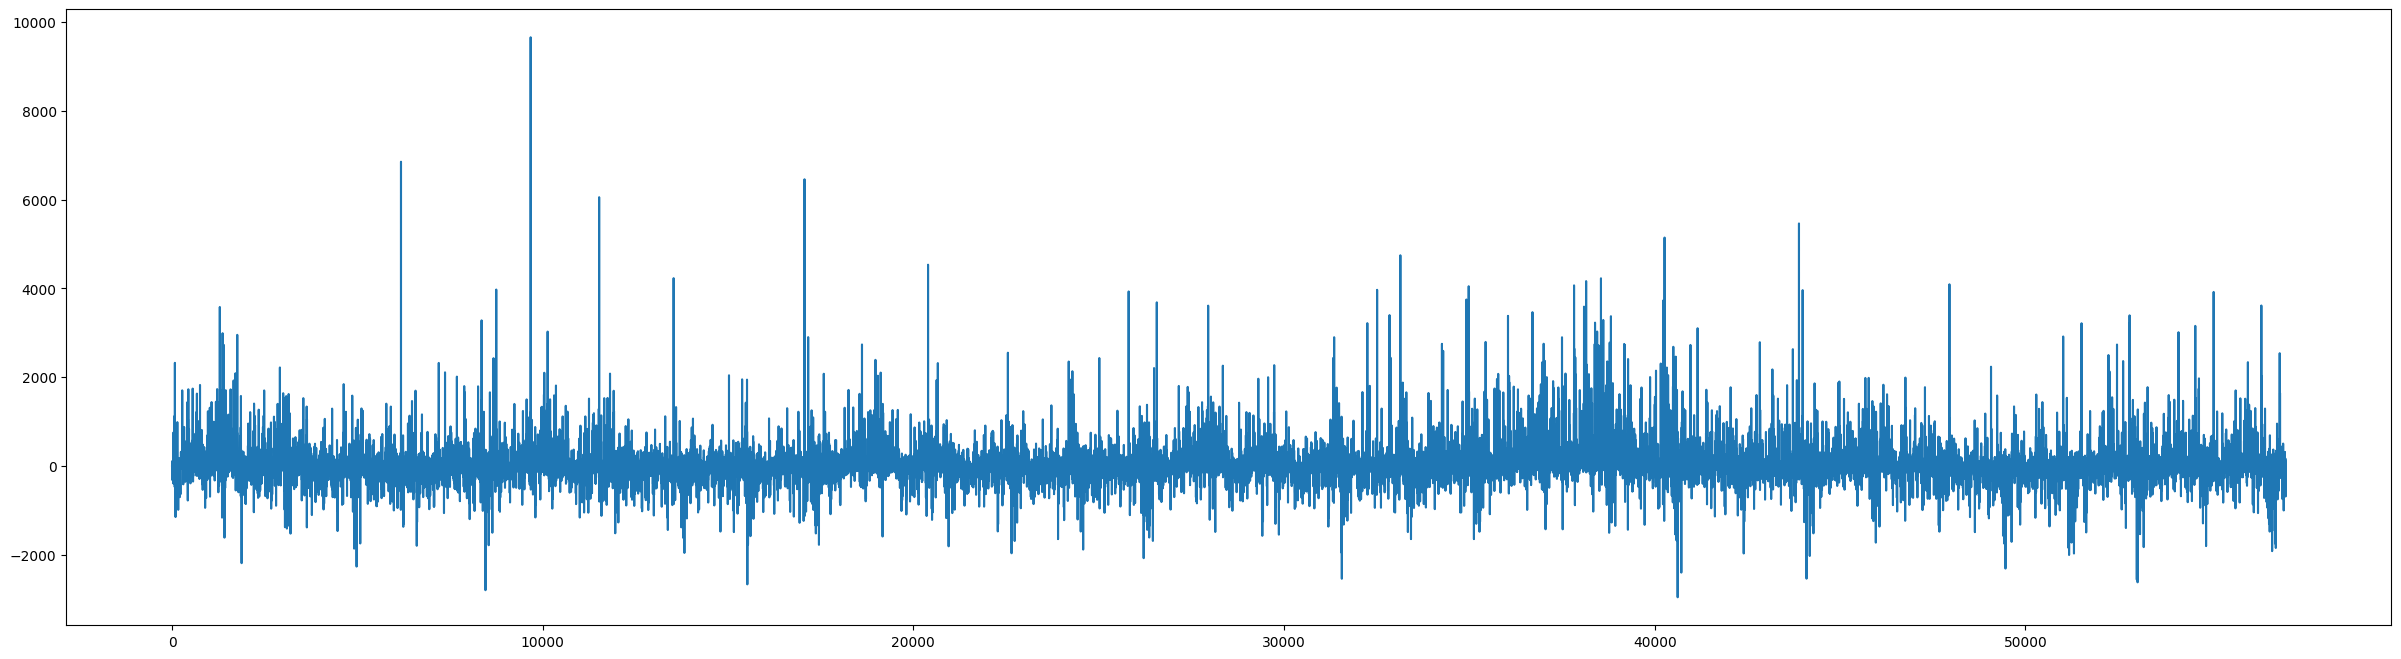

In [88]:
import matplotlib.pyplot as plt

err = target_test - pred
err_arr = [i for i in range(0, len(err))]
plt.figure(figsize=(30,8))
plt.plot(err_arr, err)

plt.show()

- 오차값의 평균

In [89]:
np.mean(err)

-4.625196136382155

### 테스트를 진행할 때 발생하는 문제
- test.csv의 날짜들에는 oil과 transection에 대한 데이터가 없다.
- 따라서 lightgbm을 이용해 기존 데이터로부터 oil과 transection을 예측하고 해당 데이터를 통해 최종 테스트를 진행한다.

### oil, transection데이터 학습

In [90]:
target_data_oil = date_updated["dcoilwtico"]
input_data_oil = date_updated.drop(columns=["sales", "dcoilwtico", "transactions", "id"])

input_train_oil = input_data_oil[:trainnum]
target_train_oil = target_data_oil[:trainnum]
input_test_oil = input_data_oil[trainnum:]
target_test_oil = target_data_oil[trainnum:]

target_data_transaction = date_updated["transactions"]
input_data_transaction = date_updated.drop(columns=["sales", "dcoilwtico", "transactions", "id"])

input_train_transaction = input_data_transaction[:trainnum]
target_train_transaction = target_data_transaction[:trainnum]
input_test_transaction = input_data_transaction[trainnum:]
target_test_transaction = target_data_transaction[trainnum:]

# input_test_oil

In [91]:
model_oil = lightgbm.LGBMRegressor()
model_transection = lightgbm.LGBMRegressor()

model_oil.fit(input_train_oil, target_train_oil)
pred_oil = model_oil.predict(input_test_oil)

model_transection.fit(input_train_transaction, target_train_transaction)
pred_transection = model_oil.predict(input_test_transaction)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 1911460, number of used features: 4
[LightGBM] [Info] Start training from score 67.169654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 1911460, number of used features: 4
[LightGBM] [Info] Start training from score 1613.021069


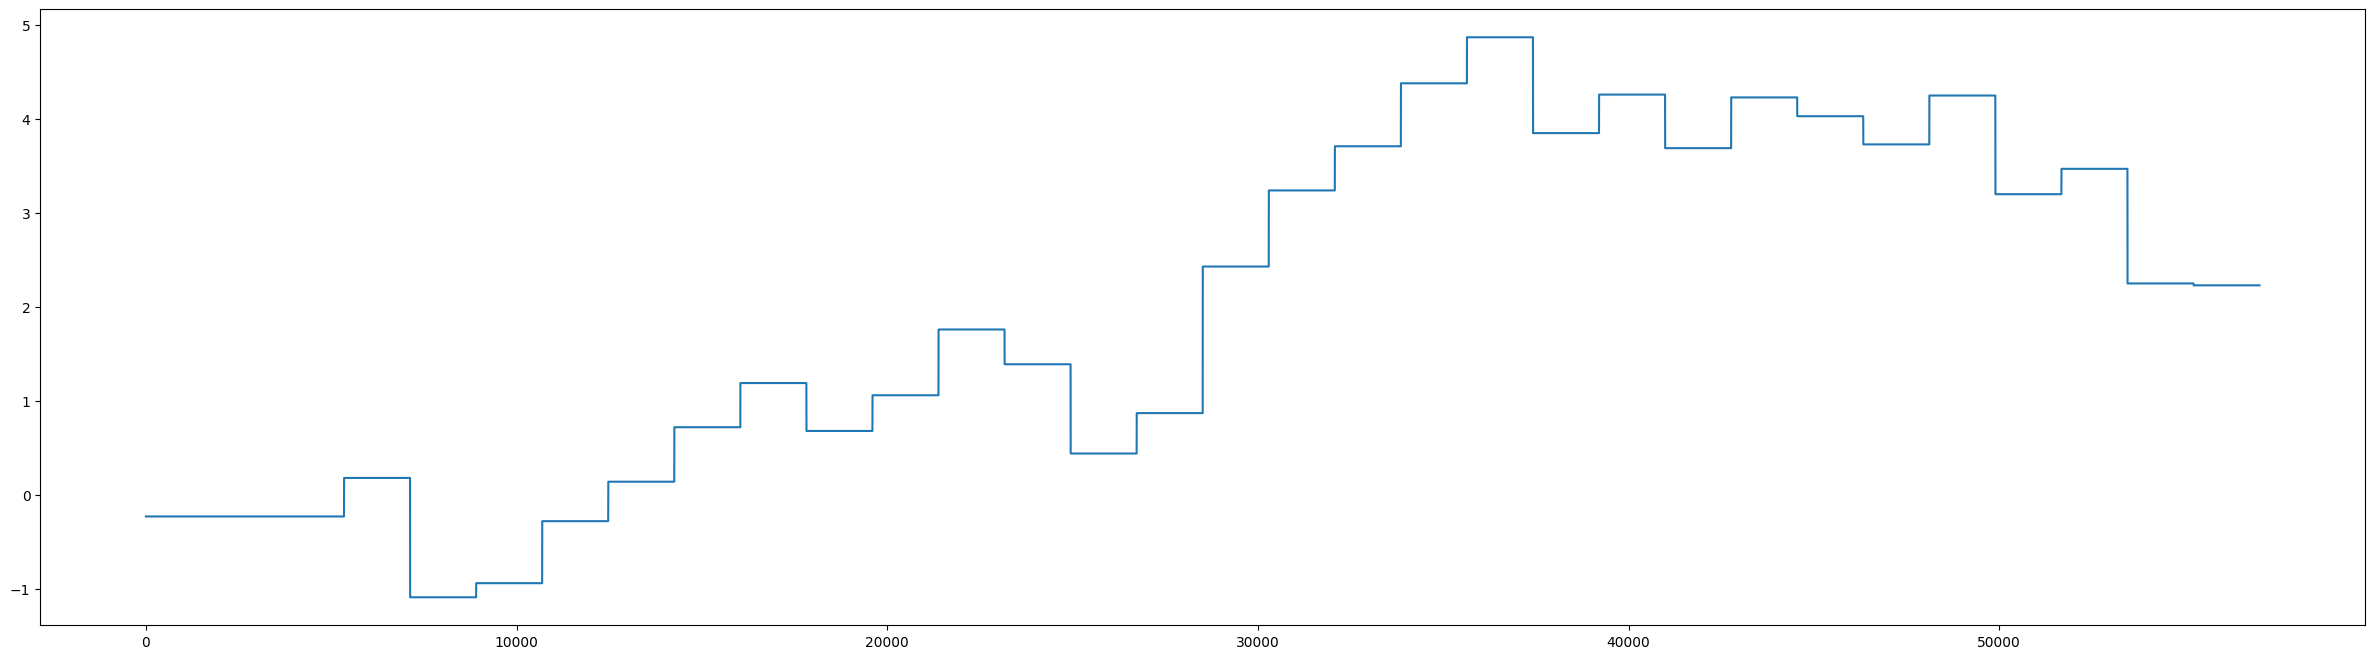

In [92]:
import matplotlib.pyplot as plt

err_oil = target_test_oil - pred_oil
err_arr_oil = [i for i in range(0, len(err_oil))]
plt.figure(figsize=(30,8))
plt.plot(err_arr_oil, err_oil)

plt.show()

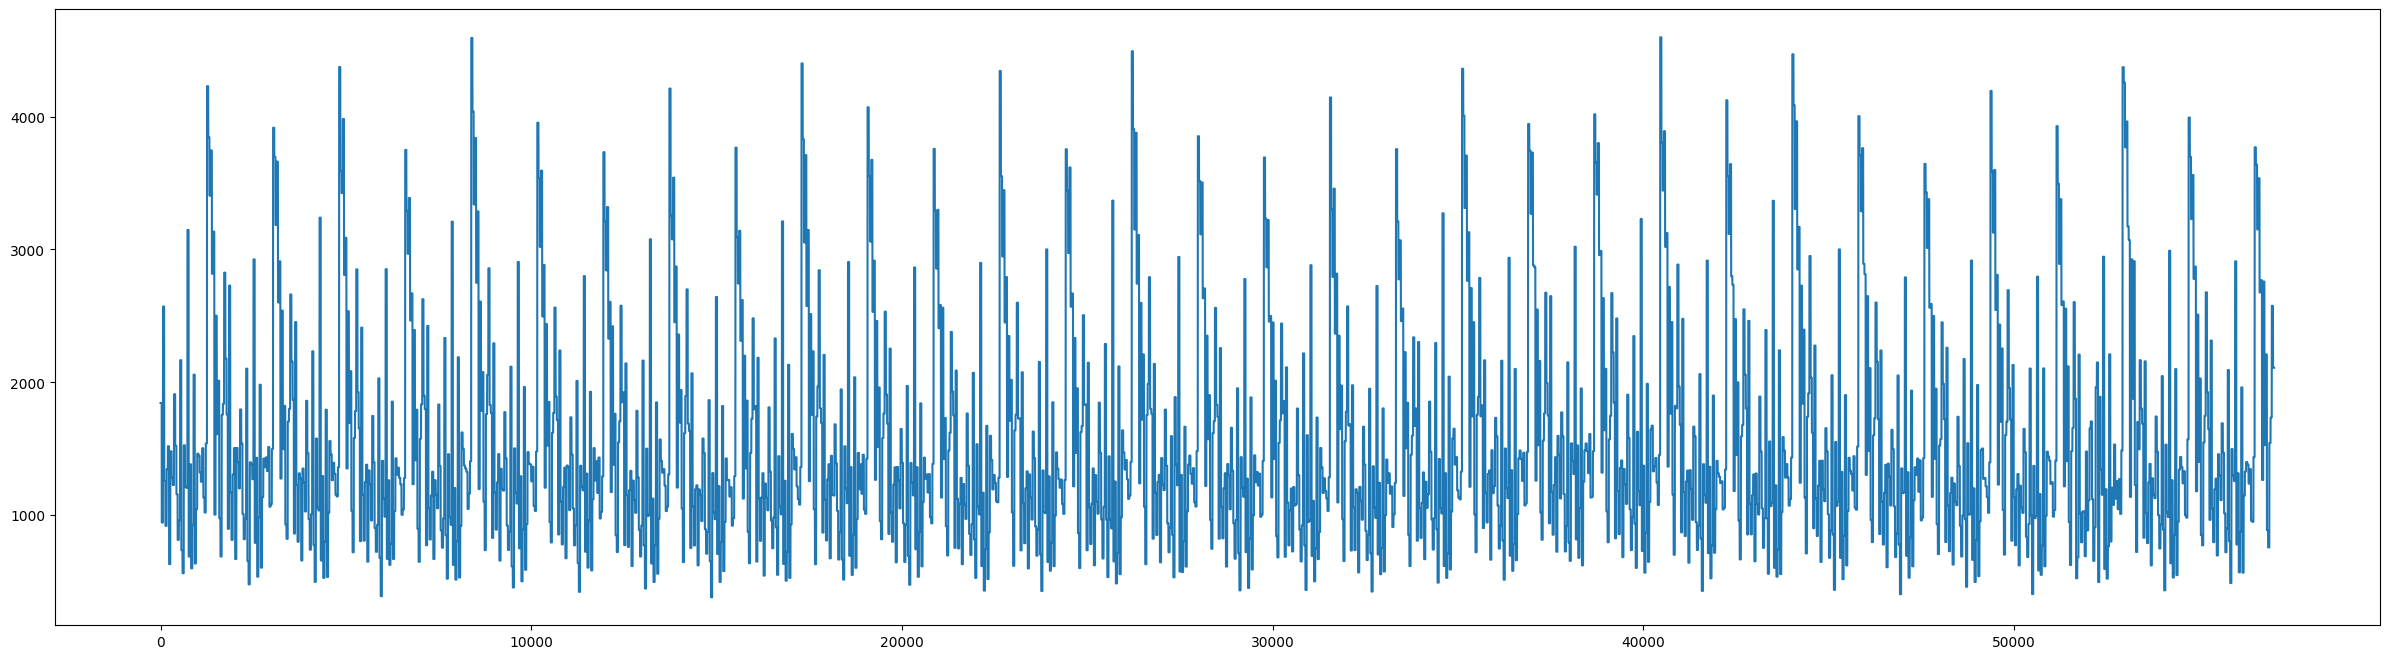

In [93]:
import matplotlib.pyplot as plt

err_transection = target_test_transaction - pred_transection
err_arr_transection = [i for i in range(0, len(err_transection))]
plt.figure(figsize=(30,8))
plt.plot(err_arr_transection, err_transection)

plt.show()

- test 데이터 가공

In [114]:
test_df["family"].replace(temp_dict, inplace=True)

# test_df = copy.deepcopy(test_df)
# print(np.array(date_updated)[:10])
test_df["date"] = test_df["date"].map(mapping)

test_df_idout = test_df.drop(columns="id")

test_df_idout

/var/folders/_r/jjv85b555y37vdkycnvxv1_w0000gn/T/ipykernel_82754/2626006801.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df["family"].replace(temp_dict, inplace=True)
/var/folders/_r/jjv85b555y37vdkycnvxv1_w0000gn/T/ipykernel_82754/2626006801.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tr

,date,store_nbr,family,onpromotion
0,201708162,1,0,0
1,201708162,1,1,0
2,201708162,1,2,2
3,201708162,1,3,20
4,201708162,1,4,0
...,...,...,...,...
28507,201708313,9,28,1
28508,201708313,9,29,0
28509,201708313,9,30,1
28510,201708313,9,31,9


- 학습한 oil데이터와 transection 모델로 예측

In [117]:
test_oil = model_oil.predict(test_df_idout)
test_transection = model_transection.predict(test_df_idout)

test_oil_df = pd.DataFrame(test_oil, columns=["dcoilwtico"])
test_transection_df = pd.DataFrame(test_transection, columns=["transactions"])

test_transection_df

,transactions
0,1703.009297
1,1703.009297
2,1706.906990
3,1707.674945
4,1703.009297
...,...
28507,1878.780852
28508,1873.337588
28509,1878.780852
28510,1879.987139


- 학습한 oil데이터와 transection 모델 합치기

In [118]:
test_df_oil_added = pd.concat([test_df_idout, test_oil_df], axis=1)
test_df_all = pd.concat([test_df_oil_added, test_transection_df], axis=1)

test_df_all

,date,store_nbr,family,onpromotion,dcoilwtico,transactions
0,201708162,1,0,0,45.340661,1703.009297
1,201708162,1,1,0,45.340661,1703.009297
2,201708162,1,2,2,45.340661,1706.906990
3,201708162,1,3,20,45.340661,1707.674945
4,201708162,1,4,0,45.340661,1703.009297
...,...,...,...,...,...,...
28507,201708313,9,28,1,45.340661,1878.780852
28508,201708313,9,29,0,45.340661,1873.337588
28509,201708313,9,30,1,45.340661,1878.780852
28510,201708313,9,31,9,45.340661,1879.987139


In [120]:
result = pd.DataFrame(model_all.predict(test_df_all), columns=['sales'])
result_id = test_df[["id"]]

# mean = train_df[["sales"]].mean(axis=0).values[0]/10
result[result <= 0] = 100

rresult = pd.concat([result_id, result], axis=1)
# mean

제출파일 생성

In [121]:
rresult.to_csv("./submission.csv",  index=False)